In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from mymodules.bcfmodel import BcfModel
from torchmetrics.classification import F1Score, BinaryF1Score
# from myutils.mydataset import MyDataset
# from myutils.myutils import draw_score_loss
import matplotlib.pyplot

In [3]:
class MyDataset(Dataset):
    def __init__(self,featureDF,targetDF) -> None:
        super().__init__()
        # self.DF = DF
        self.targetDF = targetDF
        self.featureDF = featureDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values).to(self.device)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values).to(self.device)

        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [4]:
dataDF = pd.read_csv('./DATA/MBTI.csv')

In [4]:
# labels = dict(zip(dataDF['type'].unique().tolist(),range(16)))
# dataDF['type'] = dataDF['type'].map(lambda x:labels[x])

In [5]:
sampled_df = dataDF.groupby('type', group_keys=False).apply(lambda x: x.sample(n=40, random_state=42))
sampled_df['type'].value_counts()

type
ENFJ    40
ENFP    40
ENTJ    40
ENTP    40
ESFJ    40
ESFP    40
ESTJ    40
ESTP    40
INFJ    40
INFP    40
INTJ    40
INTP    40
ISFJ    40
ISFP    40
ISTJ    40
ISTP    40
Name: count, dtype: int64

In [6]:
dataDF = dataDF.drop(columns=dataDF.columns[0])

In [7]:
featureDF = sampled_df['posts']
targetDF = np.array(sampled_df['type'].str.contains('N').astype('int8'))

In [8]:
# 문자열 데이터를 벡터화
vectorizer = TfidfVectorizer(max_features=1000,min_df=5)
vectorizer = vectorizer.fit(sampled_df['posts'].to_numpy().reshape(-1))

In [9]:
vds = []
vts = []
for i,e in enumerate(featureDF.to_numpy()):
    dataStr = e.split(' ')
    npStr = np.array(dataStr).reshape(-1)
    for v in vectorizer.transform(npStr).toarray():
        vds.append(v)
        vts.append(targetDF[i])

In [10]:
featureDF = pd.DataFrame(vds)

In [11]:
targetDF = pd.DataFrame(vts)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,targetDF,stratify=targetDF, test_size=0.2, random_state=42)

In [13]:
targetDF.shape[0] == featureDF.shape[0]

True

In [14]:
class BcfModel(nn.Module):
    # 모델구조 구성 및 인스턴스 생성 메서드
    def __init__(self,in_in,* in_out):
        super().__init__()
        self.in_layer = nn.Linear(in_in,in_out[0])
        self.h_layer = nn.ModuleList([nn.Linear(in_out[i],in_out[i+1]) for i in range(len(in_out)-1)])
        self.out_layer = nn.Linear(in_out[-1],1)

    # 순방향 학습 진행 메서드
    def forward(self,x):
        y=self.in_layer(x)      # f1w1 + f2w2 + f3w3 + b 결과 10
        y=F.relu(y)             # 0 <= y
        for layer in self.h_layer:
            y=layer(y)
            y=F.relu(y)
        return F.sigmoid(self.out_layer(y))         # 2진분류 출력층은 sigmoid() 액티베이션 펑션 활성화 함수

In [15]:
bcfmodel = BcfModel(1000,800,600,400,200)

In [16]:
trainDS = MyDataset(X_train,y_train)
valDS = MyDataset(X_test,y_test)

In [25]:
EPOCHS = 1000
BATCH_SIZE = batch_size=X_train.shape[0]//100
LR = 0.001

In [18]:
trainDL = DataLoader(trainDS,BATCH_SIZE)

In [19]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer = optim.Adam(bcfmodel.parameters(),lr=LR)

# 손실함수 인스턴스 => 분류 => 2진분류 BinaryCrossEntropyLoss => BCELoss()
#                            예측값은 확률값으로 전달 ==> sigmoid() AF 처리후 전달
regLoss = nn.BCELoss()

In [26]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]
BREAK_SCORE_CNT = 0
BREAK_LOSS_CNT = 0
for epoch in range(EPOCHS):
    # 학습 모드로 모델 설정
    bcfmodel.train()
    # 배치크기만큼 데이터 로딩해서 학습
    total_loss, total_score = 0,0
    for featureTS, targetTS in trainDL:
        # 학습 진행
        y_pre = bcfmodel(featureTS)

        # 손실 계산
        loss = regLoss(y_pre,targetTS)
        total_loss += loss.item()

        # 성능평가 계산
        score = BinaryF1Score()(y_pre,targetTS)
        total_score += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    bcfmodel.eval()
    with torch.no_grad():
        # 검증데이터셋
        val_feature = valDS[:][0]
        val_target = valDS[:][1]

        # 추론 / 평가
        pre_val = bcfmodel(val_feature)

        # 손실
        loss_val=regLoss(pre_val,val_target)
        
        # 성능평가
        score_val=BinaryF1Score()(pre_val,val_target)

    # 손실값과 성능악악값 저장
    LOSS_HISTORY[0].append(total_loss/len(trainDL))
    SCORE_HISTORY[0].append(total_score/len(trainDL))
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)
    if len(LOSS_HISTORY[1]) >= 2:
        if LOSS_HISTORY[1][-1] >= LOSS_HISTORY[1][-2]:
            BREAK_LOSS_CNT +=1
            
    # Score기준
    if len(SCORE_HISTORY[1]) >= 2:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]:
            BREAK_SCORE_CNT +=1 
    
    # 학습중단 여부 설정
    if (BREAK_LOSS_CNT >= 20) or (BREAK_SCORE_CNT >= 20):
        if BREAK_LOSS_CNT >= 20:print(f'LOSS 변화 없음 EPOCH 종료 (epoch: {epoch})')
        else : print(f'SCORE 변화 없음 EPOCH 종료 (epoch: {epoch})')
        break

SCORE 변화 없음 EPOCH 종료 (epoch: 36)


테스트 로스: 0 테스트 점수: 0


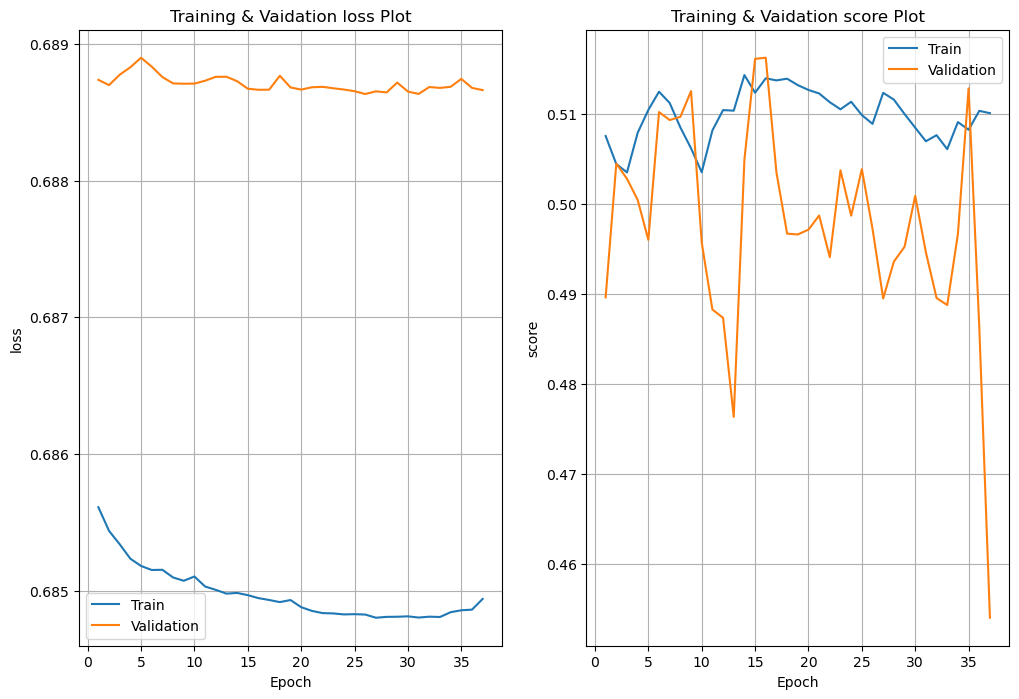

In [27]:
draw_score_loss(LOSS_HISTORY,SCORE_HISTORY)